$Expected FTB Booking and #Expected FTB Accounts

For each representative (opportunity owner) in Pre-FTB report, collect all the accounts under their name, together with Expected FTB Date (simply 'date') and Annual hotel spend (simply 'spend').

Starting from the date, split the spend over the following twelve months. Start with the month the date belongs to. (There are some strange cases, e.g. Adam Ward, Frontier Building Corp, FTB date = 30 Nov, i.e. the end of the month already, but Nov takes one entire 12th part.)

Some accounts don't have a date. I'm ignoring those.

For each month, sum these fractions over all the accounts. Also count the number of accounts. These numbers are the $Expected FTB Booking and #Expected FTB Accounts respectively, and they're shown in the Pipeline Summary.

Treat 'post' data in the same way.

There's a little difference in the number of post accounts. That's because i don't count accounts with $0.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Filter or ignore the warning
import warnings
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# Import Data

In [3]:
from datetime import datetime, timedelta
from utils import find_date_range, extract_date

In [4]:
df_pre = pd.read_csv('original_files/Pre-FTB_Report.csv')
df_post = pd.read_csv('original_files/Post-FTB_Report.csv')

df_pre['Annual hotel spend'] = df_pre['Annual hotel spend'].fillna(0).astype(int)
df_post['Annual hotel spend'] = df_post['Annual hotel spend'].fillna(0).astype(int)

In [5]:
# difference in the input files from pre to post
# the FTB includes both date and time
df_pre[:3]

,Opportunity Owner,Account Name,Opportunity Name,Stage,Expected FTB Date,Annual hotel spend,Account: Last Activity
0,Ashley Blok,Paragon Sports Constructors,Paragon Sports Constructors,Demo,NaN,250001,11/8/2022
1,Zac Oliver,JBS USA,JBS USA,Discovery,NaN,4000000,9/9/2021
2,Shane Figueroa,Holladay Properties,Holladay Properties,Discovery,11/30/2022,50001,12/8/2022


In [6]:
df_post[:3]

,Opportunity Owner,Account Name,Opportunity Name,Stage,FTB or Revival Date,Annual hotel spend,Account: Last Activity
0,Shane Figueroa,Statewide Construction Sweeping,Statewide Construction Sweeping-,Closed Won,4/25/22 11:07,0,12/7/2022
1,Shane Figueroa,KCI Enterprises,KCI Enterprises-,Closed Lost,10/30/22 22:37,0,12/8/2022
2,Shane Figueroa,Installation Services,Installation Services-,Closed (Too Small),8/23/22 14:02,20000,11/29/2022


In [7]:
#  we just need the date
df_post['Expected FTB Date'] = [extract_date(date_time) for date_time in df_post['FTB or Revival Date'] ]
df_post = df_post.drop('FTB or Revival Date', axis=1)
df_post[:3]

,Opportunity Owner,Account Name,Opportunity Name,Stage,Annual hotel spend,Account: Last Activity,Expected FTB Date
0,Shane Figueroa,Statewide Construction Sweeping,Statewide Construction Sweeping-,Closed Won,0,12/7/2022,04/25/2022
1,Shane Figueroa,KCI Enterprises,KCI Enterprises-,Closed Lost,0,12/8/2022,10/30/2022
2,Shane Figueroa,Installation Services,Installation Services-,Closed (Too Small),20000,11/29/2022,08/23/2022


# Owners

In [8]:
pre_owners = np.sort(np.array(df_pre['Opportunity Owner'].unique()))
post_owners = np.sort(np.array(df_post['Opportunity Owner'].unique()))

missing_owners = [owner for owner in pre_owners if owner not in post_owners]

In [9]:
missing_owners

['Will Gotsch']

In [10]:
print(len(pre_owners))
print(len(post_owners))

43
42


In [11]:
# I will only keep owners that are in both pre and post reports

# Convert arrays to sets
set1 = set(pre_owners)
set2 = set(post_owners)

# Find the intersection of the sets
common_elements = set1.intersection(set2)

# Convert the common elements set back to a list
names = list(common_elements)

# sort it alphabetically by family name
owners_list = sorted(names, key=lambda x: x.split()[1])

#owners_list

# Common Code for Customer Detail

In [12]:
def customer_detail(df,owner):

    # select the data you need:
    df0 = df[df['Opportunity Owner']==owner]
    df1 = df0.dropna(subset=['Expected FTB Date'])
    df2 = df1[['Account Name','Expected FTB Date','Annual hotel spend']]
    
    # Define the range using the first and second dates
    start_date_str = find_date_range(df2['Expected FTB Date'])[0]
    end_date_str = find_date_range(df2['Expected FTB Date'])[1]

    # Convert the start and end dates to datetime objects
    start_date = datetime.strptime(start_date_str, "%m/%d/%Y")
    end_date = datetime.strptime(end_date_str, "%m/%d/%Y")

    # Add one year to the end date
    end_date_plus_one_year = end_date + timedelta(days=365)

    # Iterate through the months and print the abbreviated month and year

    col = [0 for i in range(len(df2))]

    current_date = start_date
    while current_date < end_date_plus_one_year:
        #print(current_date.strftime("%b %Y"))
        df2[str(current_date.strftime("%b %Y"))] = col
        current_date += timedelta(days=30) 
    
    for i in range(len(df2)): # loop over accounts for given owner
        start_date = df2.at[df2.index[i],'Expected FTB Date']
        spend = df2.at[df2.index[i],'Annual hotel spend']
        # Convert the date string to a datetime object
        date = datetime.strptime(start_date, "%m/%d/%Y")
        # loop over the following 12 months
        for j in range(12):
            label = date.strftime("%b %Y")  # Format the date as "Abbreviated Month Year"
            df2.at[df2.index[i],label] = round(spend/12)
            # Add 30 days to the date for the next month
            date += timedelta(days=30)
        # to make sure empty months don't return NaN when divided by zero:
        df2.fillna(int(0), inplace=True, downcast='infer')     


    # This reproduces the content of "Prospect (Pre-FTB) detail"
    # Now I need to reproduce "Customers (Post-FTB) Detail"
    # and "Pipeline Summary"

    sorted_df2 = df2.sort_values(by='Annual hotel spend',ascending=False)
    
    return sorted_df2

In [13]:
def partial_pipeline_summary( detail , detail_type ):
    # detail type can be either 'pre' or 'post'
    
    numeric_columns = detail.select_dtypes(include='number')
    cols = numeric_columns.columns

    # Here are the first two lines of "Pipeline Summary":

    numeric_columns = detail.select_dtypes(include='number')
    df1exp = (pd.DataFrame(numeric_columns.sum()))
    df2exp = pd.DataFrame((detail[cols] != 0).sum())

    if detail_type == 'pre':
        label1 = '$ Expected FTB Booking'
        label2 = '# Expected FTB Accounts'
    if detail_type == 'post':
        label1 = '$ Confirmed Pipeline Bookings'
        label2 = '# Confirmed Pipeline Accounts'

    df1exp.rename(columns={0: label1}, inplace=True)
    df2exp.rename(columns={0: label2}, inplace=True)

    df_exp = (pd.concat([df1exp, df2exp], axis=1)[1:]).transpose()

    return df_exp

In [16]:
ownerID = 0
owner = owners_list[ownerID]

detail_pre = customer_detail(df_pre,owner)
detail_post = customer_detail(df_post,owner)

print(owner)

Justine Bannon


In [17]:
detail_pre[:2]

,Account Name,Expected FTB Date,Annual hotel spend,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Mar 2023,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024
547,AfterDisaster,1/25/2023,307200,0,0,25600,25600,25600,25600,25600,25600,25600,25600,25600,25600,25600,25600,0,0
790,Warrior Steel Erection Corp.,12/9/2022,216000,0,18000,18000,18000,18000,18000,18000,18000,18000,18000,18000,18000,18000,0,0,0


In [18]:
detail_post[:2]

,Account Name,Expected FTB Date,Annual hotel spend,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Mar 2023,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023
1028,Roebbelen Contracting,04/18/2022,330070,0,0,0,27506,27506,27506,27506,27506,27506,27506,27506,27506,27506,27506,27506,0,0,0,0,0,0,0,0
1067,MCM Construction,09/08/2022,300000,0,0,0,0,0,0,0,0,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,0,0,0


In [19]:
partial_pipeline_summary( detail_pre , detail_type = 'pre' )

,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Mar 2023,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024
$ Expected FTB Booking,4167,58002,145688,137355,149855,149855,149855,149855,149855,149855,149855,149855,145688,87686,4167,4167
# Expected FTB Accounts,1,9,23,22,24,24,24,24,24,24,24,24,23,14,1,1


In [20]:
partial_pipeline_summary( detail_post , detail_type = 'post' )

,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Mar 2023,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023
$ Confirmed Pipeline Bookings,33335,54170,103839,168845,209411,253996,271497,335914,385248,432748,451499,463499,442664,377412,368827,290488,266588,222003,196169,134252,86584,43251,24500
# Confirmed Pipeline Accounts,7,12,22,32,37,45,50,58,64,69,73,74,69,57,53,42,39,31,25,17,11,7,3


# Partial Visualizations

In [21]:
def vialualize_partial_pipeline (detail,detail_type):


    if detail_type == 'pre':
        label1 = '$ Expected FTB Booking'
        label2 = '# Expected FTB Accounts'
        color = 'C0'
    if detail_type == 'post':
        label1 = '$ Confirmed Pipeline Bookings'
        label2 = '# Confirmed Pipeline Accounts'
        color = 'C1'

    df_exp = partial_pipeline_summary( detail , detail_type)


    ax = (df_exp.T).plot(kind='bar',
                    y=label1,
                    rot=90, width=0.8, edgecolor='black',
                    legend=False,
                    title=label1,
                    color = color);
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_linewidth(1.2)   # Left spine
    ax.spines['bottom'].set_linewidth(1.2) # Bottom spine
    ax.spines['right'].set_visible(False) # Right spine
    ax.spines['top'].set_visible(False)   # Top spine

    # Format y-axis tick labels
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    #plt.legend()
    
    # Display the plot and then close it
    plt.show()
    plt.close()
    
    #Otherwise
    #return plt;

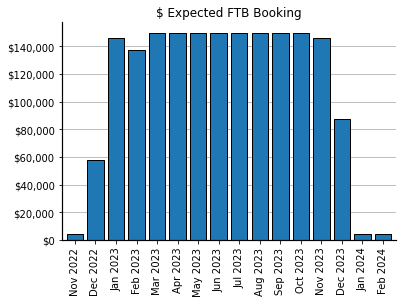

In [22]:
vialualize_partial_pipeline (detail_pre,detail_type='pre')

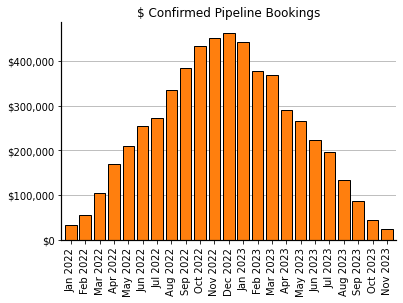

In [23]:
vialualize_partial_pipeline (detail_post,detail_type='post')

# Pipeline